In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
os.chdir("/Users/burke/Documents/research/bpCog/microsim")
from microsim.population import NHANESDirectSamplePopulation
from microsim.dementia_model import DementiaModel
from microsim.outcome import OutcomeType
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person
from microsim.education import Education
from microsim.outcome_model_repository import OutcomeModelRepository

import pandas as pd
import numpy as np

import multiprocessing as mp
#mp.set_start_method('forkserver')

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### compare our baseline to brookmeyer

In [ ]:
pop = NHANESDirectSamplePopulation(50000, 1999)
pop.advance_multi_process(20)

In [ ]:
simIncidence = pop.get_raw_incidence_by_age(OutcomeModelType.DEMENTIA)
simIncidenceTrunc = simIncidence.loc[(simIncidence.index >=20) & (simIncidence.index < 90)]
predIncidence = .084*np.exp(0.142 * (simIncidenceTrunc.index-60))/100

In [ ]:

plt.plot(range(20,90), simIncidenceTrunc, label="simulation")
plt.plot(range(20,90), predIncidence.values, label="comparison standard")
plt.legend()

### upshot...without recalibration, we're badly overpredicting.

### Below is code to try and fit the parametres on the whole model (this has previously been done for 

In [2]:
def runParameters(linearMutiplier, quadraticMultiplier, popSize=40000):
    # get dataframe on dementia indidcne
    # calculate incidence by age 
    demModel = DementiaModel()
    demModel.one_year_linear_cumulative_hazard =  demModel.one_year_linear_cumulative_hazard * linearMutiplier
    demModel.one_year_quad_cumulative_hazard =  demModel.one_year_quad_cumulative_hazard * quadraticMultiplier


    print(f"lienar multiplier: {linearMutiplier}, linaer haz {demModel.one_year_linear_cumulative_hazard}, quad multiplier: {quadraticMultiplier}, quad hazard: {demModel.one_year_quad_cumulative_hazard}")
    pop = NHANESDirectSamplePopulation(n=popSize, year=1999)
    pop._outcome_model_repository._models[OutcomeModelType.DEMENTIA] = demModel
    pop.advance_multi_process(20)
    
    incidence = pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)
    incidence = incidence.loc[(incidence.index >=60) & (incidence.index < 90)]

    predIncidence = pd.Series(index=incidence.index, data=(.084*np.exp(0.142 * (incidence.index-60))/100))
    
    # compare to brookmeu    
    mse = ((incidence-predIncidence)**2).mean()

    return (incidence, mse, linearMutiplier, quadraticMultiplier)

In [3]:
linearMultipliers = [0.1, 0.5, 0.9]
quadMultipliers = [0.01, 0.05, 0.1]


results = []
count = 0

for lin in linearMultipliers:
    for quad in quadMultipliers:
        print(f"COUNT: {count}")
        results.append(runParameters(lin, quad, 30000))
        count += 1
saveResultsToNotOverwrite = results

COUNT: 0
lienar multiplier: 0.1, linaer haz 1.33371239e-06, quad multiplier: 0.01, quad hazard: 5.64485841e-07
processing year: 0
processing year: 1
processing year: 2
processing year: 3
processing year: 4
processing year: 5
processing year: 6
processing year: 7
processing year: 8
processing year: 9
processing year: 10
processing year: 11
processing year: 12
processing year: 13
processing year: 14
processing year: 15
processing year: 16
processing year: 17
processing year: 18
processing year: 19
COUNT: 1
lienar multiplier: 0.1, linaer haz 1.33371239e-06, quad multiplier: 0.05, quad hazard: 2.8224292050000002e-06
processing year: 0
processing year: 1
processing year: 2
processing year: 3
processing year: 4
processing year: 5
processing year: 6
processing year: 7
processing year: 8
processing year: 9
processing year: 10
processing year: 11
processing year: 12
processing year: 13
processing year: 14
processing year: 15
processing year: 16
processing year: 17
processing year: 18
processing

In [6]:
resultsDF = pd.DataFrame({'mse' : [result[1] for result in results], 
                          'lin' : [result[2] for result in results],
                         'quad' : [result[3] for result in results]})
resultsDF.sort_values('mse', inplace=True)

In [ ]:
import pickle
with open( "resultsFromParameterRunQuad.p", "wb") as pickleFile:
    pickle.dump( saveResultsToNotOverwrite,  pickleFile )

In [7]:
resultsDF

,mse,lin,quad
1,0.000008,0.1,0.05
7,0.000012,0.9,0.05
4,0.000016,0.5,0.05
6,0.000095,0.9,0.01
2,0.000161,0.1,0.10
3,0.000163,0.5,0.01
5,0.000178,0.5,0.10
8,0.000185,0.9,0.10
0,0.000201,0.1,0.01


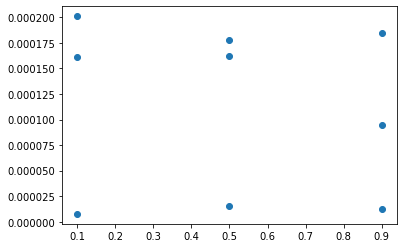

In [8]:
plt.scatter(resultsDF.lin, resultsDF.mse)

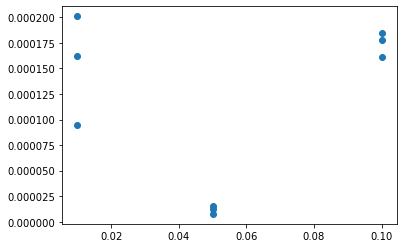

In [9]:
plt.scatter(resultsDF.quad, resultsDF.mse)

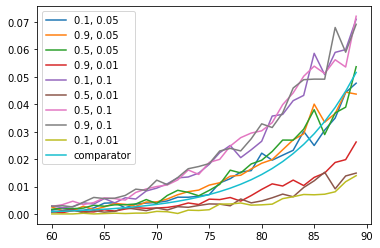

In [10]:
count = 0
for i in resultsDF.iterrows():
    if count > 10:
        break
    index = i[0]
    resultsForMult = results[int(index)][0]
    predIncidence = .084*np.exp(0.142 * (resultsForMult.index-60))/100
    
    plt.plot(resultsForMult.index, resultsForMult.values, label=f'{i[1].lin}, {i[1].quad}')
    count += 1

plt.plot(results[0][0].index, predIncidence, label='comparator')
plt.legend()


In [ ]:

index = 28
print(f"shape: {resultsDF.iloc[index]['shape']}, scale: {resultsDF.iloc[index]['scale']}")
bestFit = saveResultsToNotOverwrite[resultsDF.iloc[1].name]

predIncidence = .084*np.exp(0.142 * (bestFit[0].index-60))/100    
plt.plot(bestFit[0].index, bestFit[0].values, label=f'best fit')
plt.plot(bestFit[0].index, predIncidence.values, label='predicted')
plt.legend()


In [2]:
# test best fit...
pop = NHANESDirectSamplePopulation(100000, 1999)
demModel = DementiaModel()
demModel.one_year_linear_cumulative_hazard =  demModel.one_year_linear_cumulative_hazard * 0.5
demModel.one_year_quad_cumulative_hazard =  demModel.one_year_quad_cumulative_hazard * 0.05
pop._outcome_model_repository._models[OutcomeModelType.DEMENTIA] = demModel

pop.advance_multi_process(20)

processing year: 0
processing year: 1
processing year: 2
processing year: 3
processing year: 4
processing year: 5
processing year: 6
processing year: 7
processing year: 8
processing year: 9
processing year: 10
processing year: 11
processing year: 12
processing year: 13
processing year: 14
processing year: 15
processing year: 16
processing year: 17
processing year: 18
processing year: 19


In [3]:
simIncidenceBestFit = pop.get_raw_incidence_by_age(OutcomeModelType.DEMENTIA)
predIncidence = .084*np.exp(0.142 * (simIncidenceBestFit.index-60))/100

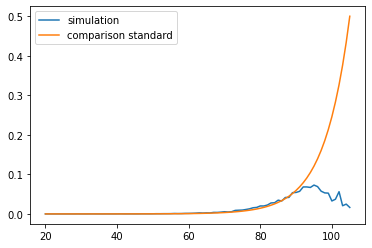

In [4]:

plt.plot(simIncidenceBestFit.index, simIncidenceBestFit, label="simulation")
plt.plot(simIncidenceBestFit.index, predIncidence.values, label="comparison standard")
plt.legend()

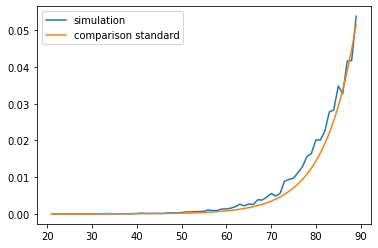

In [7]:
simIncidenceBestFitTrunc = simIncidenceBestFit.loc[(simIncidenceBestFit.index > 20) & (simIncidenceBestFit.index <90)]
predIncidenceTrunc = .084*np.exp(0.142 * (simIncidenceBestFitTrunc.index-60))/100

plt.plot(simIncidenceBestFitTrunc.index, simIncidenceBestFitTrunc, label="simulation")
plt.plot(simIncidenceBestFitTrunc.index, predIncidenceTrunc.values, label="comparison standard")
plt.legend()

In [3]:
# test best fit...
pop = NHANESDirectSamplePopulation(20000, 1999)
pop.advance_multi_process(20)

processing year: 0
processing year: 1
processing year: 2
processing year: 3
processing year: 4
processing year: 5
processing year: 6
processing year: 7
processing year: 8
processing year: 9
processing year: 10
processing year: 11
processing year: 12
processing year: 13
processing year: 14
processing year: 15
processing year: 16
processing year: 17
processing year: 18
processing year: 19


In [4]:
simIncidenceBestFit = pop.get_raw_incidence_by_age(OutcomeModelType.DEMENTIA)
predIncidence = .084*np.exp(0.142 * (simIncidenceBestFit.index-60))/100

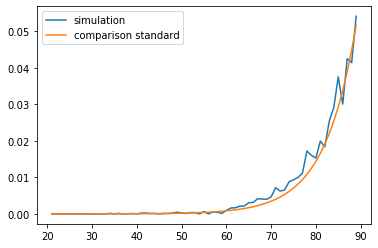

In [5]:
simIncidenceBestFitTrunc = simIncidenceBestFit.loc[(simIncidenceBestFit.index > 20) & (simIncidenceBestFit.index <90)]
predIncidenceTrunc = .084*np.exp(0.142 * (simIncidenceBestFitTrunc.index-60))/100

plt.plot(simIncidenceBestFitTrunc.index, simIncidenceBestFitTrunc, label="simulation")
plt.plot(simIncidenceBestFitTrunc.index, predIncidenceTrunc.values, label="comparison standard")
plt.legend()

### the upshot is that we're probably over-predicting by comparison to brookmeyer

its not entirely clear what happens over age 80, but given that our risk goes up, it seems likely that we're just running out of candidates to develop dementia — patients have either died or already develepd it (at 5-10% per year from 60-80...poretty much everybody is going to have it by 85!)

### here is a trial to get shape/scale parameters to fit directly without accounting for the whole simluation nonense

In [ ]:
demModel = DementiaModel()
unadvancedPopulation = NHANESDirectSamplePopulation(n=1000000, year=1999)
linPredsForBaseAge = {person._age[0] : demModel.linear_predictor(person) for i,person in unadvancedPopulation._people.iteritems()}

In [ ]:
scaleMultipliers = np.arange(0.01, 5, 0.05)
shapeMultipliers = np.arange(0.01, 5, 0.05)

ageRange = range(20, 100)
timeRange = range(0, 30)
predIncidence = .084*np.exp(0.142 * (pd.Series(ageRange)-60))/100

In [ ]:
directResults = []

def addCumulativeHazardForAge(timeRange, shape, scale, age, linPred, cumulativeHazardForAge):
    for time in timeRange:
        demModel = DementiaModel()
        demModel.shapeParameter = demModel.shapeParameter * shape
        demModel.scalingFactor = demModel.scalingFactor * scale
        cumulativeHazardForAge[baseAge + time] = demModel.get_cumulative_hazard_for_lp(linPred, time)


for scale in scaleMultipliers:
    for shape in shapeMultipliers:
        cumulativeHazardForAge = {age : [] for age in ageRange}
        for baseAge, linPred in linPredsForBaseAge.items():
            addCumulativeHazardForAge(ageRange, shape, scale, baseAge, linPred, cumulativeHazardForAge)
        cumHaz = pd.Series(index=cumulativeHazardForAge.keys(), data=[pd.Series(risks).mean() for _, risks in cumulativeHazardForAge.items()])
        predIncidence = pd.Series(index=cumHaz.index, data=.084*np.exp(0.142 * (cumHaz.index-60))/100)
        
        mse = ((pd.Series(cumHaz[60:90])- pd.Series(predIncidence[60:90]))**2).mean()
        directResults.append((scale, shape, mse, cumulativeHazardForAge))
            
            

In [ ]:
directResultsDF = pd.DataFrame({'scale' : [result[0] for result in directResults], 
                         'shape' : [result[1] for result in directResults],
                         'mse' : [result[2] for result in directResults]})



In [ ]:
directResultsDF.sort_values('mse', inplace=True)

In [ ]:
directResultsDF

In [ ]:
plt.scatter(directResultsDF.scale, directResultsDF.mse)

In [ ]:
plt.scatter(directResultsDF['shape'], directResultsDF.mse)

In [ ]:
bestFitResults = directResults[2010][3]
bestFitCumHaz = pd.Series(index=cumulativeHazardForAge.keys(), data=[pd.Series(risks).mean() for _, risks in bestFitResults.items()])

plt.plot(bestFitCumHaz[20:90], label='Best Fit')

predIncidence = pd.Series(index=bestFitCumHaz.index, data=.084*np.exp(0.142 * (bestFitCumHaz.index-60))/100)


plt.plot(predIncidence[20:90], label='Calibration Standard')
plt.legend()

In [ ]:
bestFitResults = directResults[2010][3]
bestFitCumHaz = pd.Series(index=cumulativeHazardForAge.keys(), data=[pd.Series(risks).mean() for _, risks in bestFitResults.items()])

plt.plot(bestFitCumHaz[20:94], label='Best Fit')

predIncidence = pd.Series(index=bestFitCumHaz.index, data=.084*np.exp(0.142 * (bestFitCumHaz.index-60))/100)


plt.plot(predIncidence[20:94], label='Calibration Standard')
plt.legend()

In [ ]:
bestFitCumHaz[70:80]

### so, we can get a decnert model...the problem is that when i plugged it into the simluation it still wildly over predi ted

In [ ]:
recalPop = NHANESDirectSamplePopulation(50000, 1999)
bestDemModel = DementiaModel()
# best fit scale = 0.91, shape = 0.61
bestDemModel.shapeParameter = bestDemModel.shapeParameter * 0.61
bestDemModel.scalingFactor = bestDemModel.scalingFactor * 0.91

recalPop._outcome_model_repository._models[OutcomeModelType.DEMENTIA] = bestDemModel

recalPop.advance_multi_process(20)

In [ ]:
bestSimIncidence = recalPop.get_raw_incidence_by_age(OutcomeModelType.DEMENTIA)
bestSimIncidence = bestSimIncidence.loc[(bestSimIncidence.index >=20) & (bestSimIncidence.index < 90)]
bestPredIncidence = pd.Series(index=bestSimIncidence.index, data=.084*np.exp(0.142 * (bestSimIncidence.index-60))/100)

In [ ]:
plt.plot(bestSimIncidence , label="simulation")
plt.plot(bestPredIncidence, label="comparison standard")
plt.legend()

In [ ]:
pd.Series(mses).idxmax()

In [ ]:
pd.Series(mses).describe()

### Playing with gompertz parameters

In [ ]:
shapeMultipliers = [0.01, 0.10, 0.25, 0.50, 1.0]

risksForMult = {}

for mult in shapeMultipliers:
    demModel = DementiaModel()
    #demModel.shapeParameter = demModel.shapeParameter * mult
    demModel.scalingFactor = demModel.scalingFactor * mult
    risks = []
    myDude = getDude()
    for year in range(0, 30):
        myDude._age.append(myDude._age[-1]+1)
        risks.append(demModel.get_risk_for_person(myDude, 1))
    risksForMult[mult] = risks

In [ ]:
for mult in risksForMult.keys():
    plt.plot(range(0, 30), risksForMult[mult][0:30], label=f"{mult}")
plt.legend()

### Scale does what it sounds like it should do...

In [ ]:
shapeMultipliers = [0.01, 0.10, 0.25, 0.50, 0.75, 0.85, 1.0]

risksForMult = {}

for mult in shapeMultipliers:
    demModel = DementiaModel()
    demModel.shapeParameter = demModel.shapeParameter * mult
    risks = []
    myDude = getDude()
    for year in range(0, 30):
        myDude._age.append(myDude._age[-1]+1)
        risks.append(demModel.get_risk_for_person(myDude, 1))
    risksForMult[mult] = risks

In [ ]:
for mult in risksForMult.keys():
    plt.plot(range(0, 30), risksForMult[mult][0:30], label=f"{mult}")
plt.legend()

### shape mostly contorls where the inflectio point occurs



# This is legacy code that was tryign to recalibrate relative to the quadratic model

### OK...here is the state of affairs...

it looks like i can get a simple strategy to fit the MSES...but, it probably requires a large population to be able to get the fit — random low event rates are otherwise going to look best.

let's try and fit a computationally intensive approach over the weekend and see if we find a good fit.

if so...great...

if not...then, the idea would be to run a SINGLE large population to get the linear predictors and then swap out the hazard functions...and do a more reliable change of the hazard function only to see how it fits. analytically, that woudl clearly be better...but, its a lot more coding work and a potential source of bugs. 

In [ ]:
test[0]

In [ ]:
test = runParameters(5.64485841e-05, 9.33371239e-05, 500)

In [ ]:
predIncidence = .084*np.exp(0.142 * (test[0].index-60))/100
explore = pd.DataFrame(test[0])
explore['predIncidence'] = predIncidence
explore['diff'] = explore[0] - predIncidence
explore['diffSquare'] = (explore[0] - predIncidence)**2


In [ ]:
explore

In [ ]:
demModel = DementiaModel()
pop = NHANESDirectSamplePopulation(n=1000, year=1999)
pop._outcome_model_repository._models[OutcomeModelType.DEMENTIA] = demModel
pop.advance_multi_process(20)

incidence = pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)

In [ ]:
plt.scatter(incidence.index, incidence.values)
predIncidence = .084*np.exp(0.142 * (incidence.index-60))
plt.plot(incidence.index, predIncidence/100, label="brookmeyer")

In [ ]:
incidence1 = runParameters(linear=5.64485841e-05, quadratic=1.33371239e-05)

In [ ]:
incidence2 = runParameters(linear=5.64485841e-05, quadratic=4.83371239e-05)

In [ ]:
incidence3 = runParameters(linear=5.64485841e-05, quadratic=9.33371239e-05)

In [ ]:
incidence1 = incidence1[:90]
incidence2 = incidence2[:90]
incidence3 = incidence3[:90]


plt.plot(incidence1.index, incidence1.values, label="baseline")
plt.plot(incidence2.index, incidence2.values, label="higher quadratic")
plt.plot(incidence3.index, incidence3.values, label="much higher quadratic")

predIncidence = .084*np.exp(0.142 * (incidence1.index-60))
plt.plot(incidence1.index, predIncidence/100, label="brookmeyer")
plt.legend()


In [ ]:
mses.sort()

In [ ]:
mses

In [ ]:
mses = [result[1] for result in results]
pd.Series(mses).describe()

In [ ]:
plt.plot(test1.index, test1.values, label="baseline")
plt.plot(test2.index, test2.values, label="higher quadratic")
plt.plot(test3.index, test3.values, label="much higher quadratic")

plt.legend()

In [ ]:
((incidence1-predIncidence)**2).sum()

In [ ]:
((incidence2-predIncidence)**2).sum()

In [ ]:
((incidence3-predIncidence)**2).sum()

In [ ]:
# first, just try some slight variations on our baseline model...
# then, see if we can run this through scipy optimize...


https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

# This was an experiment to see if I could reproduce overall popluaton risks with just the dmeentia + mortality models (to speed up recalibration). Short answer seems to be "No"

### getting baseline risk from the model for the average patient in our sample

In [ ]:
pop = NHANESDirectSamplePopulation(n=100000, year=1999)

In [ ]:
unadvancedPopulation = NHANESDirectSamplePopulation(n=100000, year=1999)

In [ ]:
# the problem (Likely amongst many...) with this approach is that we have to kill people off still

ageRange = range(18, 120)
timeRange = range(0, 30)

dementiaForAge = {age : [] for age in ageRange}
mortalityForAge = {age : [] for age in ageRange}
demModel = DementiaModel()
modelRepo = OutcomeModelRepository()

linPredsAndBaseAge = {person : demModel.linear_predictor(person) for i,person in unadvancedPopulation._people.iteritems()}

for time in timeRange:
    for person in unadvancedPopulation._people:
        linPred = linPredsAndBaseAge[person] 
        age = person._age[0] + time
        cumHazard = demModel.get_cumulative_hazard_for_lp(linPred, time)
        dementiaForAge[int(age)].append(cumHazard)
        mortalityForAge[age].append(modelRepo.get_risk_for_person(person, OutcomeModelType.NON_CV_MORTALITY))



In [ ]:
shortAgeRange = range(20,90)
demMinusMortality = [pd.Series(dementiaForAge[age]).mean() - pd.Series(mortalityForAge[age]).mean() for age in ageRange]

plt.plot(shortAgeRange, demMinusMortality[20:90], label='incidence after substracting mortalitly')
plt.plot(shortAgeRange, predIncidence[20:90], label='pred incidencer')




In [ ]:

for person in unadvancedPopulation._people:
    mortalityForAge[person._age[-1]]
    

In [ ]:
ageMort = [pd.Series(mortalityForAge[age]).mean() for age in ageRange]
plt.plot(ageRange, ageMort)



In [ ]:
pop.advance_multi_process(timeRange.stop)

In [ ]:
simIncidence = pop.get_raw_incidence_by_age(OutcomeType.DEMENTIA)

In [ ]:
predIncidence = [.084*np.exp(0.142 * (age-60))/100 for age in ageRange]

In [ ]:
shortAgeRange = range(20,90)
plt.plot(shortAgeRange, [pd.Series(hazardsForAge[age]).mean() for age in ageRange][20:90], label='incidence, no mortality')
plt.plot(shortAgeRange, predIncidence[20:90], label='predicted Incidence')
# is going to break on this line...need to get this over the correct age range
plt.plot(shortAgeRange, simIncidence[20:89], label='simulated Incidence')


plt.legend()

In [ ]:
plt.plot(shortAgeRange, simIncidence[20:89], label='simulated Incidence')



In [ ]:
len(range(20,90))

In [ ]:
# next step will be to build add the overall mortality model (+/- a litlte fudge factor to accoutn for CV mortality
# and see if we get closer to the sim resultnedsu)

In [ ]:
simIncidence

In [ ]:
np.trapz(simIncidence[20:84])

In [ ]:
np.trapz(predIncidence[20:85])

In [ ]:
linPredsBackOutAge = [tup[0] - tup[1]._age[-1]* demModel.ageFactor for tup in linPreds]
meanLinPredBackOutAge = pd.Series(linPredsBackOutAge).mean()

In [ ]:
ageRange = range(60, 90)
cumHazAge = []
cumHazTime = []


time = 1

for age in ageRange:
    lpForAge = meanLinPredBackOutAge + age*demModel.ageFactor
    cumHazAge.append(demModel.get_cumulative_hazard_for_lp(lpForAge, 1))
    cumHazTime.append(demModel.get_cumulative_hazard_for_lp(meanLinPredBackOutAge + ageRange.start*demModel.ageFactor, time))

    time += 1
    
predIncidence = [.084*np.exp(0.142 * (age-60))/100 for age in ageRange]

plt.plot(ageRange, cumHazAge, label='baseline model by age')
plt.plot(ageRange, cumHazTime, label='baseline model by time')

plt.plot(ageRange, predIncidence, label='brookermeyer')
plt.legend()

In [ ]:
ageRange.start